In [164]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy import ndimage
import math

In [165]:
pixelReplace = 1
pourcentage = 8
taille_fenetre = 800


id_patient = 9
path = 'C:/Users/Sanchez/Documents/JFR/DATA/patient_' + str(id_patient)

In [166]:
fichiers_dicom = [os.path.join(path, fichier) for fichier in os.listdir(path) if fichier.endswith('.dcm')]
fichiers_dicom.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

nombre_de_fichiers = len(fichiers_dicom)
nombre_a_afficher = int(nombre_de_fichiers * (pourcentage / 100))

derniers_fichiers_dicom = []
derniers_fichiers_dicom_brut = [] 
for fichier in fichiers_dicom[-nombre_a_afficher:]:
    dernier_fichier = pydicom.dcmread(fichier)
    derniers_fichiers_dicom_brut.append(dernier_fichier)
    derniers_fichiers_dicom.append(dernier_fichier.pixel_array)

In [167]:
# Function to take care of teh translation and windowing. 
def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale: 
        img = (img - img_min) / (img_max - img_min)*255.0 
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [168]:
def cancelNoise(data):
    Width = 600
    Level = 600
    
    image = data.pixel_array
    window_center, window_width, intercept, slope = get_windowing(data)
    
    output = window_image(image, Level, Width, intercept, slope, rescale = True)

    return output

derniers_fichiers_dicom_WT_Noise =  list(map(cancelNoise, derniers_fichiers_dicom_brut))

print(len(derniers_fichiers_dicom_WT_Noise))

48


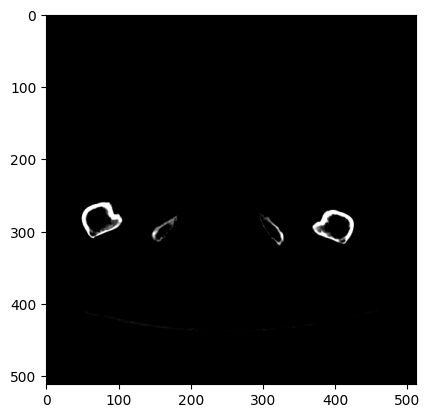

In [169]:
plt.imshow(derniers_fichiers_dicom_WT_Noise[len(derniers_fichiers_dicom_WT_Noise) - 1], cmap= 'gray')
plt.show()

In [170]:
def create_video(lsit):
    nom_video_sortie = 'video_patient' + str(id_patient) + '.avi'
    codec = cv2.VideoWriter_fourcc(*'XVID')
    fps = 10  
    largeur, hauteur = pydicom.dcmread(fichiers_dicom[0]).pixel_array.shape
    video_writer = cv2.VideoWriter(nom_video_sortie, codec, fps, (largeur, hauteur))

    for image in lsit:
        image = (image / np.max(image) * 255).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convertissez en image couleur
        video_writer.write(image)

    video_writer.release()

def color_bone(x, max_pixel):
        if x > max_pixel - 2000 :
            return pixelReplace
        else :
            return 0

def nb_bone(matrice):
    etiquettes, nombre_de_formes = ndimage.label(matrice > 0.6)
    res = []
    for i in range(1, nombre_de_formes + 1):  
        pixels_forme = (etiquettes == i)
        coordonnees_pixels = np.argwhere(pixels_forme)
        if len(coordonnees_pixels) < 300 :
            continue

        centre_x = np.mean(coordonnees_pixels[:, 0])
        centre_y = np.mean(coordonnees_pixels[:, 1])
        
        etiquettes[int(centre_x)][int(centre_y)] = pixelReplace 

        #print(f"Centre de la forme {i} : ({centre_x}, {centre_y})")
        res.append((centre_x, centre_y))


    return res

[(230.15012106537532, 221.57384987893462), (231.07256235827666, 258.70975056689343), (279.4154929577465, 71.89964788732394), (290.0437436419125, 402.9348931841302), (309.05920205920205, 140.15057915057915), (314.05569620253164, 334.59746835443036), (431.9447513812155, 336.64088397790056)]
[(230.77611940298507, 222.10945273631842), (231.50338600451468, 258.6117381489842), (279.96905393457115, 71.31388152077807), (290.1714285714286, 403.0173469387755), (309.1282722513089, 140.3324607329843), (314.47416020671835, 334.43152454780363)]
[(231.1196172248804, 222.47846889952154), (232.34977578475338, 258.7578475336323), (280.34278122232064, 71.0044286979628), (290.50854271356786, 403.63316582914575), (309.15866666666665, 140.57066666666665), (314.6875834445928, 334.3805073431242)]
[(231.88073394495413, 222.8165137614679), (233.2393736017897, 258.9776286353468), (280.7413024085638, 70.81266726137378), (290.34591836734694, 403.51938775510206), (309.5372124492558, 140.69012178619755), (314.862718

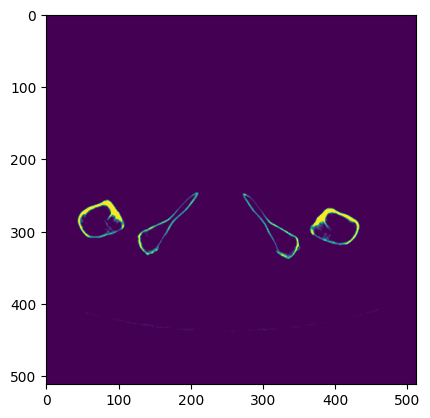

In [171]:
Bone_Image = []
femur_center = nb_bone(derniers_fichiers_dicom_WT_Noise[-1])
for fichier in derniers_fichiers_dicom_WT_Noise:
    image_matrice = fichier
    new_image =  image_matrice
    femur_center = nb_bone(image_matrice)
    print(femur_center)
    for x,y in femur_center:
        for i in range(-5, 6):
            new_image[int(x + i)][int(y)] = pixelReplace 
            new_image[int(x)][int(y + i)] = pixelReplace 

    x1,y1 = femur_center[0]
    x2,y2 = femur_center[1]

    x3,y3 = int((x1 + x2) /2), int((y1 + y2)/2 )
    for i in range(-10, 11):
        new_image[int((x1 + x2) /2) + i][int((y1 + y2)/2 )] = pixelReplace 
        new_image[int((x1 + x2) /2)][int((y1 + y2)/2 ) + i] = pixelReplace 
    Bone_Image.append(new_image)

plt.imshow(Bone_Image[len(Bone_Image)//2])
plt.show()


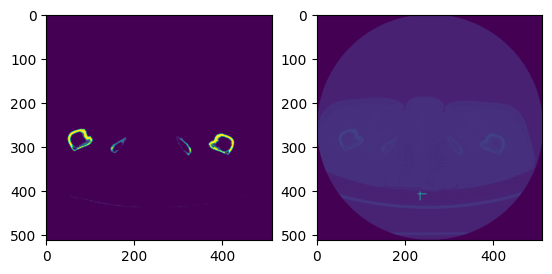

In [172]:
res = []
for new_image in Bone_Image:
    dx = x2 - x1
    dy = y2 - y1
    d = -120
    norme = math.sqrt(dx**2 + dy**2)

    # Normalisation du vecteur 
    ux = dx / norme
    uy = dy / norme

    vx = -uy
    vy = ux

    vx *= d
    vy *= d

    x = x3 + vx
    y = y3 + vy

    for i in range(-10, 11):
            new_image[int(x + i)][int(y)] = pixelReplace 
            new_image[int(x)][int(y + i)] = pixelReplace 
    res.append((new_image,(x, y)))


image, center = res[len(res)-1]
plt.figure()

plt.subplot(1,2, 1)
plt.imshow(image)
plt.subplot(1,2, 2)


image_cross = np.copy(derniers_fichiers_dicom[len(res)-1])
for i in range(-5, 15):
            image_cross[int(x + i)][int(y)] = pixelReplace +20000
            image_cross[int(x)][int(y + i)] = pixelReplace +20000
plt.imshow(image_cross)
plt.show()


5182
HOMME


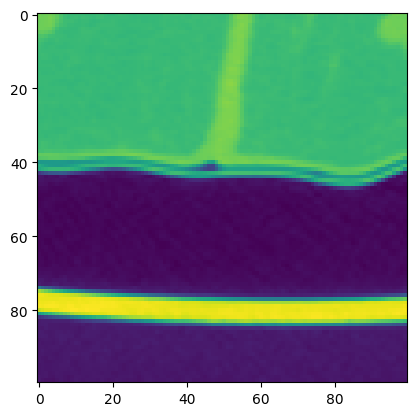

In [173]:
taille_f = 100 # pixels = taille_f **2 
image = derniers_fichiers_dicom[len(res)//2 ]

final_image = image.astype("float32")
final_image /= np.max(final_image)
#final_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2RGB)


fenetre = final_image[int(x - taille_f // 2) : int(x + taille_f // 2 ),
            int(y - taille_f // 2 ): int(y + taille_f // 2 )]

pixels_blanc = np.count_nonzero(fenetre > 0.2)
print(pixels_blanc)
if pixels_blanc > 5000 :
    print("HOMME")
else:
    print("FEMME")

plt.imshow(fenetre)
plt.show()
